In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from collections import Counter
import re
import random

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [31]:
def cleanPrideAndPrejudice(file_path):
    with open(file_path, "r") as f:
        text = f.read()

    start_idx = text.find("CHAPTER I.")
    if start_idx == -1:
        return text
    text = text[start_idx:]

    end_idx = text.find("Transcriber's note:")
    if end_idx != -1:
        text = text[:end_idx]

    text = re.sub(r"CHAPTER\s+[IVXLCDM]+", "", text)

    return text


def cleanUllyeses(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()

    first_idx = text.find("— I —")
    if first_idx == -1:
        return text

    second_idx = text.find("— I —", first_idx + 1)
    if second_idx == -1:
        return text
    text = text[second_idx:]

    text = re.sub(r"—\s+[I|II|III]+\s+—", "", text)

    text = re.sub(r"\[\s*\d+\s*\]", "", text)

    end_idx = text.find("Trieste-Zurich-Paris")
    if end_idx != -1:
        text = text[:end_idx]

    return text

def Tokenizer(inputText):
    text = inputText.lower()
    text = text.replace("\n", " ")
    text = re.sub(r"http\S+", "<URL>", text)
    text = re.sub(r"www\S+", "<URL>", text)
    text = re.sub(r"[A-Za-z0-9._%+-]+@[A-za-z0-9.-]+\.[a-z]{2,}", "<MAILID>", text)

    text = re.sub(r"[^\@\#\.\w\?\!\s:-]", "", text)
    text = re.sub(f"-", " ", text)
    text = re.sub(r"_", " ", text)

    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\n*", "", text)
    text = re.sub(r"\.+", ".", text)

    abbreviations = re.findall(r"\b([A-Z]([a-z]){,2}\.)", text)
    if abbreviations:
        abbreviations_set = set((list(zip(*abbreviations))[0]))

        for word in abbreviations_set:
            pattern = r"\b" + re.escape(word)
            text = re.sub(pattern, word.strip("."), text)

    text = re.sub(r"#\w+\b", "<HASHTAG>", text)
    text = re.sub(r"@\w+\b", "<MENTION>", text)
    text = re.sub(r"\b\d+\b", "<NUM>", text)

    # Tokenize each sentence into words
    sentences = [
        sentence.strip() for sentence in re.split(r"[.!?:]+", text) if sentence.strip()
    ]
    sentences = [sentence.split() for sentence in sentences]

    return sentences

def trainTestSplit(sentences, testSize):
    random.seed(69)

    testSplit = random.sample(sentences, testSize)
    duplicateTestSplit = testSplit.copy()
    trainSplit = [
        sentence
        for sentence in sentences
        if sentence not in duplicateTestSplit or duplicateTestSplit.remove(sentence)
    ]

    return trainSplit, testSplit

In [32]:
# file_path = input("Enter Corpus Path: ")
# n = input("Enter value of N: ")

file_path = 'corpus/corpus_2.txt'
filteredText = ""
corp = ""

# corpus cleaning and tokenization
if 'corpus_1.txt' in file_path:
    filteredText = cleanPrideAndPrejudice(file_path)
    corp = "papc"
elif 'corpus_2.txt' in file_path:
    filteredText = cleanUllyeses(file_path)
    corp = "uc"
else:
    print("Corpus doesn't exist!")
    exit()

In [33]:
sentences = Tokenizer(filteredText)

In [34]:
train_text, test_text = trainTestSplit(sentences, 1000)

In [35]:
max(len(sentence) for sentence in train_text)

12906

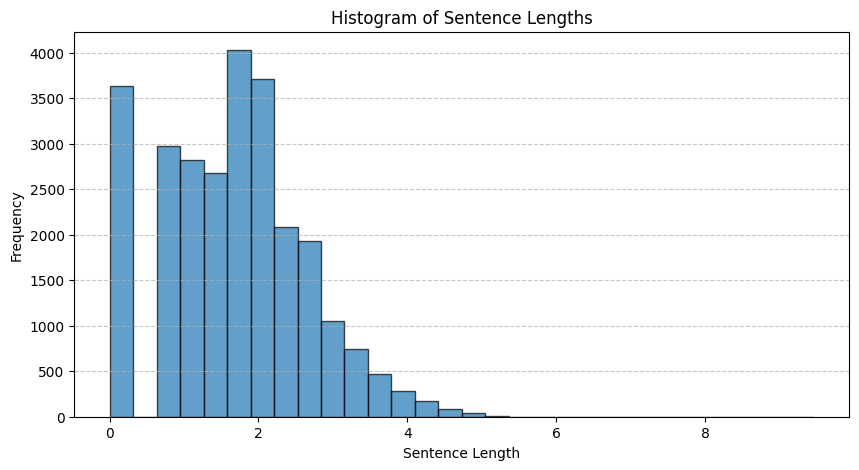

Histogram saved at sentence_length_uc.png


In [36]:
import matplotlib.pyplot as plt

def plot_sentence_length_histogram(sentences, save_path="sentence_length_histogram.png"):
    """
    Plots and saves a histogram of sentence lengths.
    Args:
        sentences (list of list of str): Tokenized sentences.
        save_path (str): Path to save the histogram image.
    """
    # Compute sentence lengths
    lengths = [np.log(len(sentence)) for sentence in sentences]
    
    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel("Sentence Length")
    plt.ylabel("Frequency")
    plt.title("Histogram of Sentence Lengths")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save and show
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Histogram saved at {save_path}")

plot_sentence_length_histogram(train_text, f"sentence_length_{corp}.png")

In [37]:
print(len(train_text))
print(len(test_text))

26744
1000


In [9]:
vocab = Counter(word for sentence in train_text for word in sentence)
word_to_idx = {word: i for i, word in enumerate(vocab.keys())}
idx_to_word = {i: word for word, i in word_to_idx.items()}

word_to_idx["<UNK>"] = len(word_to_idx)
idx_to_word[len(idx_to_word)] = "<UNK>"

In [10]:
print(len(word_to_idx))

5960


In [11]:
print(f"Vocab Size: {len(word_to_idx)}")

Vocab Size: 5960


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class TextDataset(Dataset):
    def __init__(self, tokenized_sentences):
        self.seq_length = max(len(sentence) for sentence in tokenized_sentences)
        
        # Flatten list of lists for vocabulary creation
        all_words = [word for sentence in tokenized_sentences for word in sentence]
        
        # Create vocabulary
        word_counts = Counter(all_words)
        self.vocab = ['<PAD>', '<UNK>'] + list(word_counts.keys())
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        
        # Convert sentences to indices and flatten
        self.data = []
        for sentence in tokenized_sentences:
            sentence_indices = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in sentence]
            self.data.extend(sentence_indices)
        
    def __len__(self):
        return max(0, len(self.data) - self.seq_length - 1)
    
    def __getitem__(self, idx):
        sequence = self.data[idx:idx + self.seq_length]
        target = self.data[idx + 1:idx + self.seq_length + 1]
        return torch.tensor(sequence), torch.tensor(target)
    

class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(VanillaRNN, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        
        if hidden is None:
            hidden = torch.zeros(1, batch_size, self.hidden_dim, device=x.device)
        
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        output = self.fc(output)
        return output, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_dim, device=device)

class LanguageModelTrainer:
    def __init__(self, model):
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        print(f"Model moved to {device}")
        
    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            self.optimizer.zero_grad()
            
            hidden = self.model.init_hidden(data.size(0))
            output, _ = self.model(data, hidden)
            
            loss = self.criterion(output.reshape(-1, output.size(-1)), target.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
            self.optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
            
        return total_loss / len(dataloader)
    
    def predict_next_words(self, input_tokens, dataset, k=5):
        """
        Predict next words given a list of input tokens
        Args:
            input_tokens: List of tokens or space-separated string
            dataset: TextDataset instance
            k: Number of top predictions to return
        """
        self.model.eval()
        
        # Handle both string and list input
        if isinstance(input_tokens, str):
            tokens = input_tokens.strip().split()
        else:
            tokens = input_tokens
            
        # Convert tokens to indices
        word_indices = [dataset.word2idx.get(word, dataset.word2idx['<UNK>']) for word in tokens]
        
        # # Trim sequence if longer than seq_length
        # if len(word_indices) > dataset.seq_length:
        #     word_indices = word_indices[-dataset.seq_length:]
        
        with torch.no_grad():
            input_tensor = torch.tensor(word_indices).unsqueeze(0).to(device)
            hidden = self.model.init_hidden(1)
            output, _ = self.model(input_tensor, hidden)
            
            probabilities = torch.softmax(output[0, -1], dim=0)
            top_k_probs, top_k_indices = torch.topk(probabilities, k)
            
            predictions = []
            for prob, idx in zip(top_k_probs.cpu().numpy(), top_k_indices.cpu().numpy()):
                word = dataset.idx2word[idx]
                predictions.append((word, prob))
                
        return predictions

def train_language_model(tokenized_sentences, embedding_dim, hidden_dim, 
                        batch_size, num_epochs):
    # Print memory usage before training
    if torch.cuda.is_available():
        print(f"GPU Memory before training: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    
    # Create dataset
    dataset = TextDataset(tokenized_sentences)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Vocabulary size: {len(dataset.vocab)}")
    
    # Initialize model
    model = VanillaRNN(len(dataset.vocab), embedding_dim, hidden_dim)
    trainer = LanguageModelTrainer(model)
    
    # Training loop
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        loss = trainer.train_epoch(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {loss:.4f}')
        
        # Print memory usage after each epoch
        if torch.cuda.is_available():
            print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    
    return model, dataset, trainer

Using device: cuda


In [13]:
# # hyperparams
# embedding_dimensions = 200
# hidden_dimensions = 512
# batch_size = 256
# epochs = 5

# model, dataset, trainer = train_language_model(train_text, embedding_dimensions, hidden_dimensions, batch_size, epochs)
# print("Training completed successfully!")

In [14]:
# # Using string
# predictions = trainer.predict_next_words("mr darcy is the real", dataset, k=10)

# print("\nTest predictions:")
# for word, prob in predictions:
#     print(f'Word: {word}, Probability: {prob:.4f}')

In [ ]:
def calculate_perplexity(model, sentences, dataset, device, batch_size=64, output_file="perplexities.txt"):
    """
    Calculate perplexity for a list of tokenized sentences using batch processing
    """
    model.eval()
    total_nll = 0
    total_words = 0
    perplexities = []
    
    # Process sentences in batches
    with torch.no_grad():
        # Convert all sentences to tensors first
        batch_data = []
        for i, sentence in enumerate(sentences):
            if len(sentence) < 2:  # Skip too short sentences
                continue
                
            indices = [dataset.word2idx.get(word, dataset.word2idx['<UNK>']) for word in sentence]
            batch_data.append((i, indices))
        
        # Process in batches
        for i in range(0, len(batch_data), batch_size):
            batch = batch_data[i:i + batch_size]
            batch_indices = []
            batch_targets = []
            sentence_lengths = []
            original_indices = []
            
            # Prepare batch data
            for idx, indices in batch:
                original_indices.append(idx)
                batch_indices.append(indices[:-1])  # All but last word
                batch_targets.append(indices[1:])   # All but first word
                sentence_lengths.append(len(indices) - 1)
            
            # Pad sequences in batch
            max_len = max(sentence_lengths)
            padded_indices = [seq + [dataset.word2idx['<PAD>']] * (max_len - len(seq)) for seq in batch_indices]
            padded_targets = [seq + [dataset.word2idx['<PAD>']] * (max_len - len(seq)) for seq in batch_targets]
            
            # Convert to tensors
            context_tensor = torch.tensor(padded_indices).to(device)
            target_tensor = torch.tensor(padded_targets).to(device)
            lengths_tensor = torch.tensor(sentence_lengths).to(device)
            
            # Get model output
            output, _ = model(context_tensor)
            
            # Calculate log probabilities
            log_probs = torch.log_softmax(output, dim=-1)
            
            # Calculate perplexity for each sentence in batch
            for j in range(len(batch)):
                length = sentence_lengths[j]
                sentence_log_probs = log_probs[j, :length]
                sentence_targets = target_tensor[j, :length]
                
                # Calculate NLL for this sentence
                nll = 0
                for t in range(length):
                    nll += -sentence_log_probs[t, sentence_targets[t]]
                
                # Calculate perplexity
                ppl_score = torch.exp(nll / length).item()
                perplexities.append(f"sentence {original_indices[j]+1}: {ppl_score:.4f}")
                
                # Update totals
                total_nll += nll.item()
                total_words += length
            
    # Write results to file
    with open(output_file, "w") as f:
        f.write("\n".join(perplexities))
    print(f"Perplexity scores saved to {output_file}")
    
    # Calculate average perplexity
    if total_words > 0:
        avg_nll = total_nll / total_words
        avg_perplexity = torch.exp(torch.tensor(avg_nll)).item()
        print(f"Average Perplexity: {avg_perplexity:.4f}")
        return avg_perplexity
    else:
        print("No valid sentences found for perplexity calculation")
        return None

In [16]:
# # Calculate perplexities for both sets
# print("Calculating training set perplexity...")
# train_perplexity = calculate_perplexity(
#     model=model,
#     sentences=train_text,
#     dataset=dataset,
#     device=device,
#     batch_size=128,
#     output_file="train_perplexities.txt"
# )

# print("\nCalculating test set perplexity...")
# test_perplexity = calculate_perplexity(
#     model=model,
#     sentences=test_text,  # Your test sentences
#     dataset=dataset,
#     device=device,
#     batch_size=128,  # Adjust based on your GPU memory
#     output_file="test_perplexities.txt"
# )

# print(f"\nFinal Results:")
# print(f"Training Set Perplexity: {train_perplexity:.4f}")
# print(f"Test Set Perplexity: {test_perplexity:.4f}")

In [ ]:
import torch
import itertools
import json
from datetime import datetime
import os

def train_and_evaluate_models(train_text, test_text, hyperparameters, base_model_dir="models", results_file="model_results.json"):
    """
    Train multiple models with different hyperparameter combinations and evaluate their perplexities
    
    Args:
        train_text: Training data (list of tokenized sentences)
        test_text: Test data (list of tokenized sentences)
        hyperparameters: Dictionary of hyperparameter lists to try
        base_model_dir: Directory to save models
        results_file: File to save results
    """
    # Create model directory if it doesn't exist
    os.makedirs(base_model_dir, exist_ok=True)
    
    # Generate all combinations of hyperparameters
    param_names = sorted(hyperparameters.keys())
    param_values = [hyperparameters[name] for name in param_names]
    param_combinations = list(itertools.product(*param_values))
    
    # Store results
    results = []
    
    # Train and evaluate each combination
    for i, params in enumerate(param_combinations):
        param_dict = dict(zip(param_names, params))
        print(f"\nTraining model {i+1}/{len(param_combinations)}")
        print("Parameters:", param_dict)
        
        # Create model identifier
        model_id = f"model_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{i}"
        
        try:
            # Train model
            model, dataset, trainer = train_language_model(
                train_text,
                embedding_dim=param_dict['embedding_dim'],
                hidden_dim=param_dict['hidden_dim'],
                batch_size=param_dict['batch_size'],
                num_epochs=param_dict['epochs']
            )
            
            # Calculate perplexities
            print("\nCalculating training perplexity...")
            train_perplexity = calculate_perplexity(
                model=model,
                sentences=train_text,
                dataset=dataset,
                device=device,
                output_file=f"{base_model_dir}/train_perplexities_{model_id}.txt"
            )
            
            print("\nCalculating test perplexity...")
            test_perplexity = calculate_perplexity(
                model=model,
                sentences=test_text,
                dataset=dataset,
                device=device,
                output_file=f"{base_model_dir}/test_perplexities_{model_id}.txt"
            )
            
            # Save model
            model_path = f"{base_model_dir}/model_{model_id}.pt"
            torch.save({
                'model_state_dict': model.state_dict(),
                'hyperparameters': param_dict,
                'train_perplexity': train_perplexity,
                'test_perplexity': test_perplexity
            }, model_path)
            
            # Store results
            result = {
                'model_id': model_id,
                'hyperparameters': param_dict,
                'train_perplexity': train_perplexity,
                'test_perplexity': test_perplexity,
                'model_path': model_path
            }
            results.append(result)
            
            # Save results after each model (in case of crashes)
            with open(results_file, 'w') as f:
                json.dump(results, f, indent=4)
                
        except Exception as e:
            print(f"Error training model with parameters {param_dict}: {str(e)}")
            continue
    
    # Find best model based on test perplexity
    best_model = min(results, key=lambda x: x['test_perplexity'])
    print("\nBest Model:")
    print(json.dumps(best_model, indent=4))
    
    return results, best_model

# Define hyperparameter grid
hyperparameters = {
    'embedding_dim': [50, 100, 200],
    'hidden_dim': [512],
    'batch_size': [256],
    'epochs': [5, 6, 7]
}

# Train and evaluate models
results, best_model = train_and_evaluate_models(
    train_text=train_text,
    test_text=test_text,
    hyperparameters=hyperparameters,
    base_model_dir=f"models_rnn_{corp}",
    results_file=f"model_results_rnn_{corp}.json"
)

# Print summary
print("\nTraining Summary:")
print(f"Total models trained: {len(results)}")
print("\nBest performing model:")
print(f"Model ID: {best_model['model_id']}")
print("Hyperparameters:", best_model['hyperparameters'])
print(f"Train Perplexity: {best_model['train_perplexity']:.4f}")
print(f"Test Perplexity: {best_model['test_perplexity']:.4f}")


Training model 1/9
Parameters: {'batch_size': 256, 'embedding_dim': 50, 'epochs': 5, 'hidden_dim': 512}
GPU Memory before training: 0.00 MB
Vocabulary size: 5961
Model moved to cuda

Epoch 1/5
Batch 0, Loss: 8.7046
Batch 100, Loss: 6.3176
Batch 200, Loss: 6.2659
Batch 300, Loss: 6.0942
Batch 400, Loss: 5.9544
Epoch 1/5, Average Loss: 6.3965
GPU Memory: 72.14 MB

Epoch 2/5
Batch 0, Loss: 5.9249
Batch 100, Loss: 5.8183
Batch 200, Loss: 5.6287
Batch 300, Loss: 5.5388
Batch 400, Loss: 5.4269
Epoch 2/5, Average Loss: 5.6514
GPU Memory: 72.14 MB

Epoch 3/5
Batch 0, Loss: 5.4065
Batch 100, Loss: 5.2949
Batch 200, Loss: 5.2128
Batch 300, Loss: 5.1568
Batch 400, Loss: 5.0636
Epoch 3/5, Average Loss: 5.2170
GPU Memory: 72.14 MB

Epoch 4/5
Batch 0, Loss: 5.0399
Batch 100, Loss: 4.9574
Batch 200, Loss: 4.8481
Batch 300, Loss: 4.7573
Batch 400, Loss: 4.6740
Epoch 4/5, Average Loss: 4.8497
GPU Memory: 72.14 MB

Epoch 5/5
Batch 0, Loss: 4.6203
Batch 100, Loss: 4.5512
Batch 200, Loss: 4.4565
Batch 30